1st we created the ukmet_results.csv in ukmet6s10w.ipynb. Now we take the results and try to predict the mixed layer depth (MLD) using 0.125kg/m3 as the threshold. 

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
df = pd.read_csv('ukmet_results.csv')
df.head()

,time,depth,temperature,salinity,SA,CT,STH_pred,rho_pred
0,2000-01-16,5.02159,26.163027,35.870613,36.040018,26.130032,23.640835,23.662184
1,2000-01-16,15.07854,26.186867,35.918091,36.087736,26.149755,23.669873,23.733967
2,2000-01-16,25.16046,26.140673,36.048550,36.218829,26.096143,23.783543,23.890479
3,2000-01-16,35.27829,26.199018,36.022953,36.193133,26.153225,23.746612,23.896517
4,2000-01-16,45.44776,25.729147,35.992920,36.163009,25.682025,23.871794,24.065177


### Testing with a month's data and trying to predict the MLD using the 0.125kg/m3 threshold.
- since we saw from pmel results that error range was upto 0.03 for density calculation, we also use a relaxed threshold of 0.15kg/m3

Low Depth (TL): 25.16046, Low Depth (TH): 35.27829
High Depth (TL): 35.27829, High Depth (TH): 45.44776
Mixed Layer Depth (MLD)[Actual threshold]: 30.219375
Mixed Layer Depth (MLD)[Corrected threshold]: 40.363025


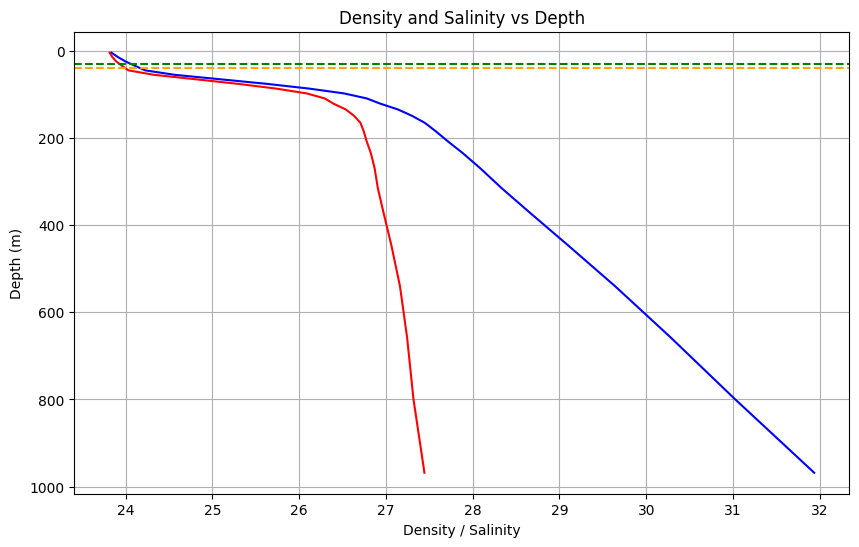

In [110]:
# take all rows with time = 2000-01-16
test_df = df[df['time'] == '2002-01-16']
t_low = 0.125
t_high = 0.2

# for test_df, find the lowest depth for which 'STH_pred' is greater than 0.125+1st row of 'STH_pred'
# and the highest depth for which 'STH_pred' is less than 0.125+1st row of 'STH_pred'
t_low += test_df['STH_pred'].iloc[0]
t_high += test_df['STH_pred'].iloc[0]

low_depth_tl = test_df[test_df['STH_pred'] < t_low]['depth'].max()
low_depth_th = test_df[test_df['STH_pred'] < t_high]['depth'].max()

high_depth_tl = test_df[test_df['STH_pred'] > t_low]['depth'].min()
high_depth_th = test_df[test_df['STH_pred'] > t_high]['depth'].min()

mld_tl = (low_depth_tl + high_depth_tl) / 2
mld_th = (low_depth_th + high_depth_th) / 2
if mld_tl != mld_th:
    print(f'Low Depth (TL): {low_depth_tl}, Low Depth (TH): {low_depth_th}')
    print(f'High Depth (TL): {high_depth_tl}, High Depth (TH): {high_depth_th}')

    print(f'Mixed Layer Depth (MLD)[Actual threshold]: {mld_tl}')
    print(f'Mixed Layer Depth (MLD)[Corrected threshold]: {mld_th}')
else:
    print(f'Low Depth: {low_depth_tl}, High Depth: {high_depth_tl}')
    print(f'Mixed Layer Depth (MLD): {mld_tl}')


# now plot 'rho_pred'and 'STH_pred' both (x-axis) vs 'depth'(y axis, inverted), connecting the points with a line
plt.figure(figsize=(10, 6))
plt.plot(test_df['rho_pred'], test_df['depth'], label='Density', color='blue')
plt.plot(test_df['STH_pred'], test_df['depth'], label='Salinity', color='red')
plt.gca().invert_yaxis()  # invert y-axis
plt.axhline(y=mld_tl, color='green', linestyle='--', label='MLD Actual')
plt.axhline(y=mld_th, color='orange', linestyle='--', label='MLD Corrected')
plt.title('Density and Salinity vs Depth')
plt.xlabel('Density / Salinity')
plt.ylabel('Depth (m)')
plt.grid()
plt.show()


Now we see that the MLD is being predicted quite correctly. We predict MLD for each month and store as mld_results.csv

In [111]:
df = pd.read_csv('ukmet_results.csv')
rows = []

# List all unique values of 'time' in df
dates = df['time'].unique()
for date in dates:
    t_low = 0.125
    t_high = 0.2

    df_date = df[df['time'] == date] #temporary df

    t_low += df_date['STH_pred'].iloc[0]
    t_high += df_date['STH_pred'].iloc[0]

    low_depth_tl = df_date[df_date['STH_pred'] < t_low]['depth'].max()
    low_depth_th = df_date[df_date['STH_pred'] < t_high]['depth'].max()
    
    high_depth_tl = df_date[df_date['STH_pred'] > t_low]['depth'].min()
    high_depth_th = df_date[df_date['STH_pred'] > t_high]['depth'].min()

    if low_depth_tl > high_depth_tl:
        low_depth_tl, high_depth_tl = high_depth_tl, low_depth_tl
    if low_depth_th > high_depth_th:
        low_depth_th, high_depth_th = high_depth_th, low_depth_th

    mld_tl = (low_depth_tl + high_depth_tl) / 2
    mld_th = (low_depth_th + high_depth_th) / 2

    # add row to results
    rows.append({
        'time': date,
        'mld_tl': mld_tl.round(2),
        'mld_th': mld_th.round(2),
        'low_depth_tl': low_depth_tl.round(2),
        'low_depth_th': low_depth_th.round(2),
        'high_depth_tl': high_depth_tl.round(2),
        'high_depth_th': high_depth_th.round(2),
    })

results = pd.DataFrame(rows)
results.to_csv('mld_results.csv', index=False)
results.head()




,time,mld_tl,mld_th,low_depth_tl,low_depth_th,high_depth_tl,high_depth_th
0,2000-01-16,30.22,40.36,25.16,35.28,35.28,45.45
1,2000-02-15,40.36,40.36,35.28,35.28,45.45,45.45
2,2000-03-16,40.36,40.36,35.28,35.28,45.45,45.45
3,2000-04-16,20.12,40.36,15.08,35.28,25.16,45.45
4,2000-05-16,50.57,60.87,45.45,55.69,55.69,66.04


### MLD Plot by year (by month)
Now, we have MLD results for each month for duration 2000-2019, we plot mld for each year (by month)

In [112]:
# WE WILL BE TAKING RELAXED THRESHOLD's MLD
# for testing plot 2000 to 2004
start_date = '2000-01-01'
end_date = '2004-12-31'
metric = 'mld_th' # mld_tl or mld_th

mld_df = pd.read_csv('mld_results.csv')
mld_df = mld_df[(mld_df['time'] >= start_date) & (mld_df['time'] <= end_date)]

mld_df['time'] = pd.to_datetime(mld_df['time'])
mld_df['year'] = mld_df['time'].dt.year
mld_df['month'] = mld_df['time'].dt.month

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

yearly_list = [] # values are [2000: { 'jan': 30.12 , ... 12 values ... corresponding to each month's mld_th} }
for year in mld_df['year'].unique():
    this_yr_mld_df = mld_df[mld_df['year'] == year]
    monthly_mld_list = []
    dic = {}
    for i, month in enumerate(months):
        dic[month] = this_yr_mld_df[this_yr_mld_df['month'] == i + 1][metric].mean()
    yearly_list.append([year,dic])

<Figure size 1200x600 with 0 Axes>

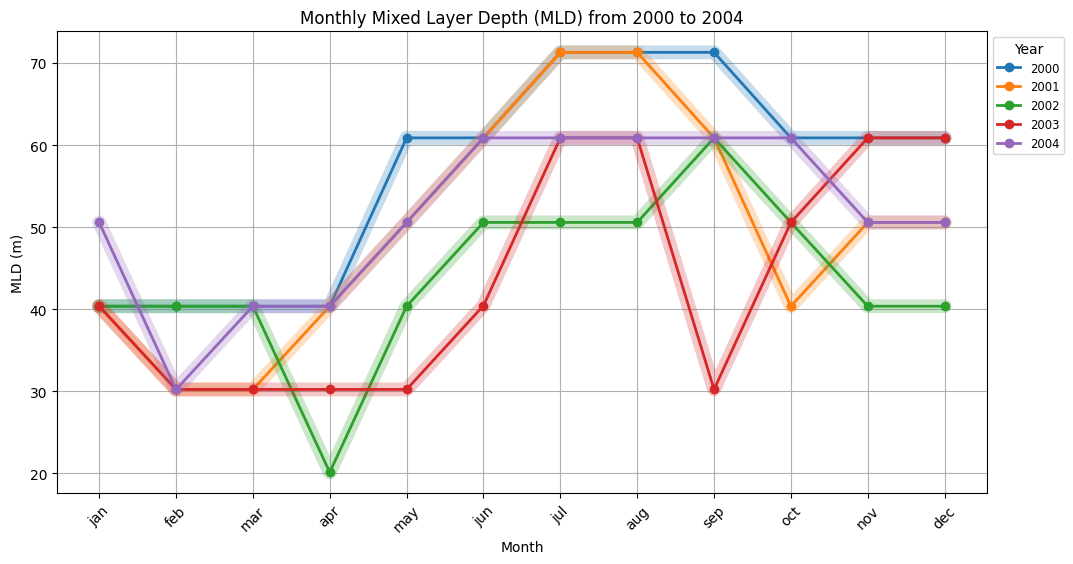

In [113]:
x_list = months
y_list = [] # list of lists
legend_list = [] 
for item in yearly_list:
    legend_list.append(item[0]) # year
    dic = item[1]
    temp = []
    for month in months:
        temp.append(dic[month])
    y_list.append(temp)

# plot
plt.figure(figsize=(12, 6))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = [c['color'] for c in list(prop_cycle)] # Extract the list of colors

# plot the data
plt.figure(figsize=(12, 6))

for i in range(len(y_list)):
    # Get the color that Matplotlib would assign to this line by default
    # Use modulo to cycle through colors if there are more lines than default colors
    current_color = colors[i % len(colors)]

    # Plot the wider, transparent line with the current_color
    plt.plot(x_list, y_list[i], color=current_color, linewidth=10, alpha=0.25, solid_capstyle='round')
    
    # Plot the original thinner line on top with the same current_color
    plt.plot(x_list, y_list[i], label=legend_list[i], marker='o', linewidth=2, color=current_color)


plt.title('Monthly Mixed Layer Depth (MLD) from 2000 to 2004')
plt.xlabel('Month')
plt.ylabel('MLD (m)')
plt.xticks(rotation=45)
# place legend outside the plot
plt.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
plt.grid(True)
# plt.tight_layout()
plt.show()

Avg MLD plot by month

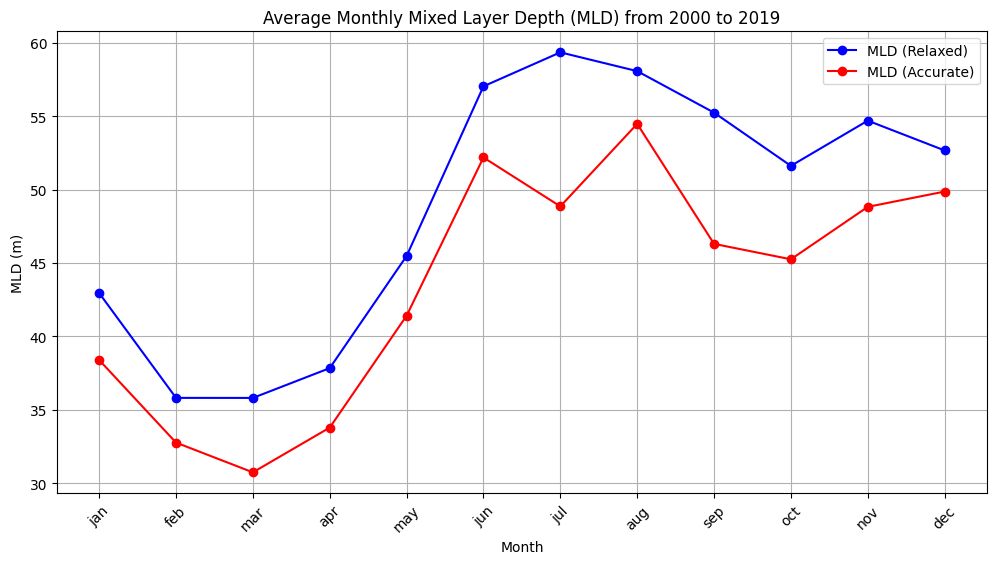

In [114]:
avg_mld_th_list = []
avg_mld_tl_list = []
df = pd.read_csv('mld_results.csv')
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
# group by month value and take mean and append to avg_mld_list
for i in range(1, 13):
    avg_mld_th_list.append(df[df['month'] == i]['mld_th'].mean())
    avg_mld_tl_list.append(df[df['month'] == i]['mld_tl'].mean())
# plot
plt.figure(figsize=(12, 6))
plt.plot(months, avg_mld_th_list, label='MLD (Relaxed)', marker='o', color='blue')
plt.plot(months, avg_mld_tl_list, label='MLD (Accurate)', marker='o', color='red')
plt.title('Average Monthly Mixed Layer Depth (MLD) from 2000 to 2019')
plt.xlabel('Month')
plt.ylabel('MLD (m)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Now we have avg MLD data by month, we predict the temp and salinity for each month interpolating data from ukmet_results.csv

C:\Users\deban\AppData\Local\Temp\ipykernel_30608\3892619899.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  depth_above_tl = month_df[month_df['depth'] >= mld_tl_mean][month_df['year'] == year]['depth'].min()
C:\Users\deban\AppData\Local\Temp\ipykernel_30608\3892619899.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  depth_below_tl = month_df[month_df['depth'] <= mld_tl_mean][month_df['year'] == year]['depth'].max()
C:\Users\deban\AppData\Local\Temp\ipykernel_30608\3892619899.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  depth_above_th = month_df[month_df['depth'] >= mld_th_mean][month_df['year'] == year]['depth'].min()
C:\Users\deban\AppData\Local\Temp\ipykernel_30608\3892619899.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  depth_below_th = month_df[month_df['depth'] <= mld_th_mean][month_df['year'] == year]['depth'].max()
C:\Users\deb

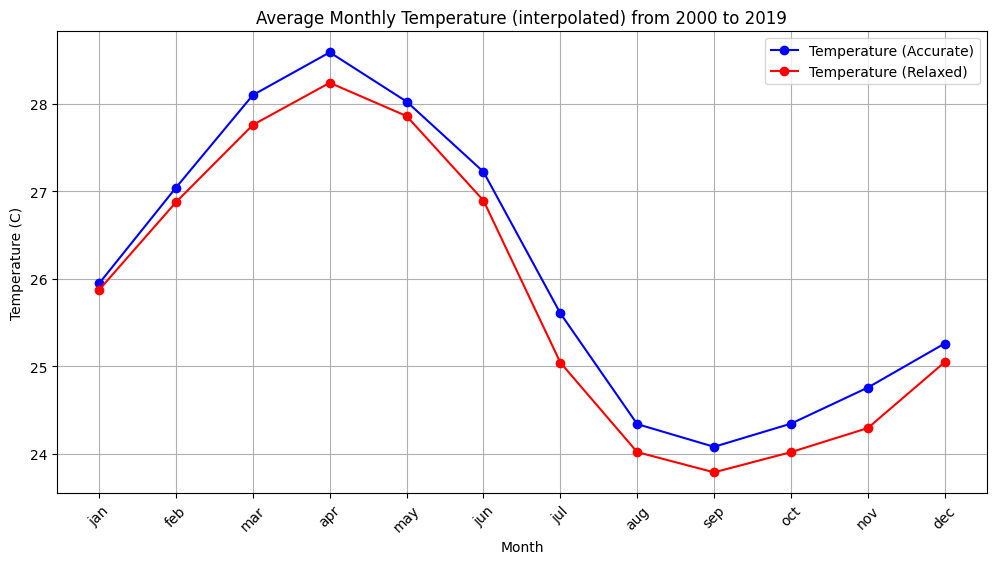

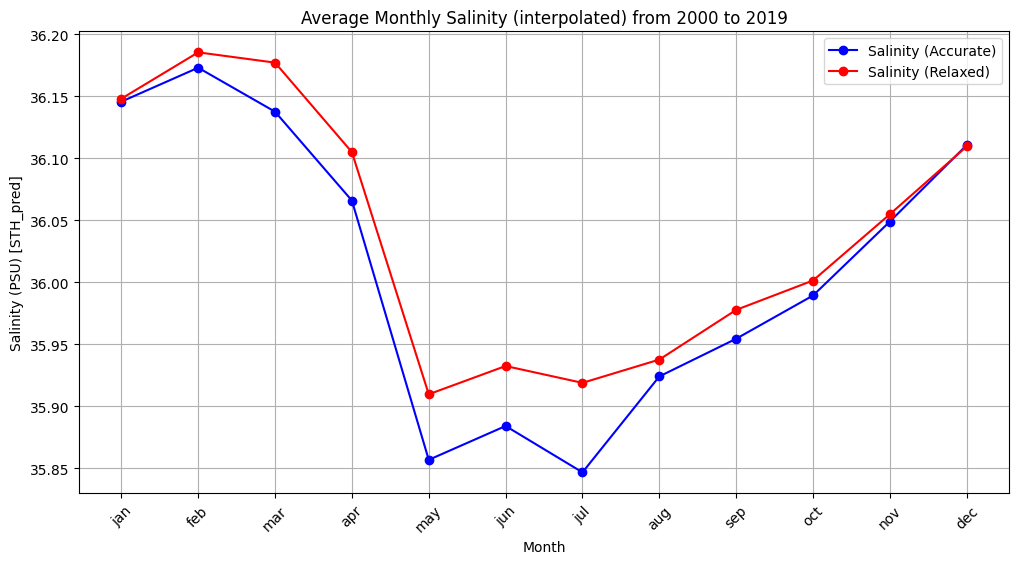

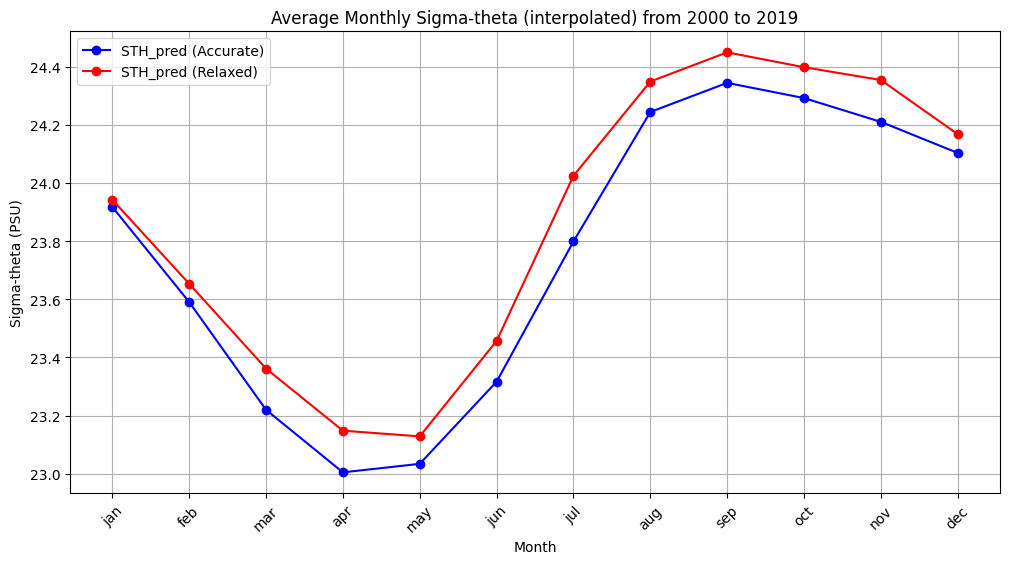

In [116]:
temp_tl_by_month = []
temp_th_by_month = []
salinity_tl_by_month = []
salinity_th_by_month = []
sth_th_by_month = []
sth_tl_by_month = []
df = pd.read_csv('ukmet_results.csv')
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

df_mld_avg = pd.DataFrame(columns=['month', 'mld_tl', 'mld_th'])
# fill the df_mld_avg with month, mld_tl, mld_th from lists months, avg_mld_tl_list, avg_mld_th_list
dic_list = []
for i in range(1, 13):
    dic = {}
    dic['month'] = months[i - 1]
    dic['mld_tl'] = avg_mld_tl_list[i - 1].round(2)
    dic['mld_th'] = avg_mld_th_list[i - 1].round(2)
    dic_list.append(dic)
df_mld_avg = pd.DataFrame(dic_list)
df_mld_avg.head()

# Now for each month, we find the just below and just above depth of the mld_tl_mean and mld_th_mean for each year
# then for each above and below depth pair, we find the corresponding pairs of salinity and temperature
# we construct a straight line between the two points in t-depth and s-depth, input the mld_tl_mean and mld_th_mean to get the corresponding salinity and temperature
for i in range(0, 12):
    mld_tl_mean = avg_mld_tl_list[i]
    mld_th_mean = avg_mld_th_list[i]
    # find the just below and just above depth of the mld_tl_mean and mld_th_mean for each year
    month_df = df[df['month'] == i + 1]
    years = month_df['year'].unique()
    temp_tl_list = []
    temp_th_list = []
    salinity_tl_list = []
    salinity_th_list = []
    sth_tl_list = []
    sth_th_list = []
    for year in years:
        depth_above_tl = month_df[month_df['depth'] >= mld_tl_mean][month_df['year'] == year]['depth'].min()
        depth_below_tl = month_df[month_df['depth'] <= mld_tl_mean][month_df['year'] == year]['depth'].max()
        depth_above_th = month_df[month_df['depth'] >= mld_th_mean][month_df['year'] == year]['depth'].min()
        depth_below_th = month_df[month_df['depth'] <= mld_th_mean][month_df['year'] == year]['depth'].max()
        # find the corresponding pairs of salinity and temperature
        salinity_above_tl = month_df[month_df['depth'] == depth_above_tl][month_df['year'] == year]['salinity'].values[0]
        salinity_below_tl = month_df[month_df['depth'] == depth_below_tl][month_df['year'] == year]['salinity'].values[0]
        salinity_above_th = month_df[month_df['depth'] == depth_above_th][month_df['year'] == year]['salinity'].values[0]
        salinity_below_th = month_df[month_df['depth'] == depth_below_th][month_df['year'] == year]['salinity'].values[0]
        temp_above_tl = month_df[month_df['depth'] == depth_above_tl][month_df['year'] == year]['temperature'].values[0]
        temp_below_tl = month_df[month_df['depth'] == depth_below_tl][month_df['year'] == year]['temperature'].values[0]
        temp_above_th = month_df[month_df['depth'] == depth_above_th][month_df['year'] == year]['temperature'].values[0]
        temp_below_th = month_df[month_df['depth'] == depth_below_th][month_df['year'] == year]['temperature'].values[0]
        sth_above_tl = month_df[month_df['depth'] == depth_above_tl][month_df['year'] == year]['STH_pred'].values[0]
        sth_below_tl = month_df[month_df['depth'] == depth_below_tl][month_df['year'] == year]['STH_pred'].values[0]
        sth_above_th = month_df[month_df['depth'] == depth_above_th][month_df['year'] == year]['STH_pred'].values[0]
        sth_below_th = month_df[month_df['depth'] == depth_below_th][month_df['year'] == year]['STH_pred'].values[0]
        # construct a straight line between the two points in t-depth and s-depth, input the mld_tl_mean and mld_th_mean to get the corresponding salinity and temperature
        # for salinity
        salinity_tl = salinity_below_tl + (salinity_above_tl - salinity_below_tl) * (mld_tl_mean - depth_below_tl) / (depth_above_tl - depth_below_tl)
        salinity_th = salinity_below_th + (salinity_above_th - salinity_below_th) * (mld_th_mean - depth_below_th) / (depth_above_th - depth_below_th)
        # for temperature
        temp_tl = temp_below_tl + (temp_above_tl - temp_below_tl) * (mld_tl_mean - depth_below_tl) / (depth_above_tl - depth_below_tl)
        temp_th = temp_below_th + (temp_above_th - temp_below_th) * (mld_th_mean - depth_below_th) / (depth_above_th - depth_below_th)
        # for STH_pred
        sth_tl = sth_below_tl + (sth_above_tl - sth_below_tl) * (mld_tl_mean - depth_below_tl) / (depth_above_tl - depth_below_tl)
        sth_th = sth_below_th + (sth_above_th - sth_below_th) * (mld_th_mean - depth_below_th) / (depth_above_th - depth_below_th)
        # append to lists
        temp_tl_list.append(temp_tl)
        temp_th_list.append(temp_th)
        salinity_tl_list.append(salinity_tl)
        salinity_th_list.append(salinity_th)
        sth_tl_list.append(sth_tl)
        sth_th_list.append(sth_th)
    # append to the lists, average the lists
    temp_tl_by_month.append(np.mean(temp_tl_list).round(4))
    temp_th_by_month.append(np.mean(temp_th_list).round(4))
    salinity_tl_by_month.append(np.mean(salinity_tl_list).round(4))
    salinity_th_by_month.append(np.mean(salinity_th_list).round(4))
    sth_tl_by_month.append(np.mean(sth_tl_list).round(4))
    sth_th_by_month.append(np.mean(sth_th_list).round(4))

# new columns to the df_mld_avg
df_mld_avg['temp_tl'] = temp_tl_by_month
df_mld_avg['temp_th'] = temp_th_by_month
df_mld_avg['salinity_tl'] = salinity_tl_by_month
df_mld_avg['salinity_th'] = salinity_th_by_month
df_mld_avg['sth_tl'] = sth_tl_by_month
df_mld_avg['sth_th'] = sth_th_by_month
df_mld_avg.to_csv('mld_avg_results.csv', index=False)

# plot the salinity and temperature for each month
plt.figure(figsize=(12, 6))
plt.plot(months, temp_tl_by_month, label='Temperature (Accurate)', marker='o', color='blue')
plt.plot(months, temp_th_by_month, label='Temperature (Relaxed)', marker='o', color='red')
plt.title('Average Monthly Temperature (interpolated) from 2000 to 2019')
plt.xlabel('Month')
plt.ylabel('Temperature (C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(months, salinity_tl_by_month, label='Salinity (Accurate)', marker='o', color='blue')   
plt.plot(months, salinity_th_by_month, label='Salinity (Relaxed)', marker='o', color='red')
plt.title('Average Monthly Salinity (interpolated) from 2000 to 2019')
plt.xlabel('Month')
plt.ylabel('Salinity (PSU) [STH_pred]')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(months, sth_tl_by_month, label='STH_pred (Accurate)', marker='o', color='blue')
plt.plot(months, sth_th_by_month, label='STH_pred (Relaxed)', marker='o', color='red')
plt.title('Average Monthly Sigma-theta (interpolated) from 2000 to 2019')
plt.xlabel('Month')
plt.ylabel('Sigma-theta (PSU)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
    